In [17]:
import pandas as pd
import io
import requests
import numpy as np
import collections
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Embedding, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# LSTM

In [30]:
dt = pd.read_csv('C:/Users/Owner/Documents/Sac State/CSC215_P2_Stock_Price.csv')
dt['Close_y'] = dt['Close']
split = int(0.7 * len(dt))
df_train = dt[:split]
df_test = dt[split:len(dt)]

print("Training set has {} records.".format(len(df_train)))
print("Test set has {} records.".format(len(df_test)))


Training set has 3074 records.
Test set has 1318 records.


Since we want to ensure time-based relationships between observations, we split the data in a sequential way. The first 70% of observations are in the training set, with the remaining in our test.
Additoinally, we create a new column 'Close_y' to preserve the actual observed closing values. This will be used as our dependent variable. This column is needed as the 'Close' column will be used as an input variable and will be normalized.

In [33]:
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
        
    if sd is None:
        sd = df[name].std()
        
    df[name] = (df[name] - mean) / sd

normal_list = ['Open', 'High', 'Low', 'Volume', 'Close'];

for element in normal_list:
    encode_numeric_zscore(df_train, element)
    encode_numeric_zscore(df_test, element)    



params_train = df_train[['Open', 'High', 'Low', 'Volume', 'Close']].values.tolist()
params_test = df_test[['Open', 'High', 'Low', 'Volume', 'Close',]].values.tolist()

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Next we normalize the values, and drop the 'date' column from the dataframe. The way we did this caused a warning, however this does not impact our final program.

In [40]:
def to_sequences(seq_size, data):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data[i+SEQUENCE_SIZE]
        window = [x for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

SEQUENCE_SIZE = 7
x_train,y_train = to_sequences(SEQUENCE_SIZE,params_train)
obs_train = df_train['Close_y'][SEQUENCE_SIZE:len(df_train)].values.tolist()
obs_train.pop()
obs_train = np.asarray(obs_train)

x_test,y_test = to_sequences(SEQUENCE_SIZE,params_test)
obs_test = df_test['Close_y'][SEQUENCE_SIZE:len(df_test)].values.tolist()
obs_test.pop()
obs_test = np.asarray(obs_test)

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(obs_train.shape))
print("Shape of y_test: {}".format(obs_test.shape))

Shape of x_train: (3066, 7, 5)
Shape of x_test: (1310, 7, 5)
Shape of y_train: (3066,)
Shape of y_test: (1310,)


Here we transform our data in sequence data. Now, each record is a sequence of 7 days of data, each with 5 relevant pieces of information on that day's market behavior. Additionally, there is one dependent variable for each of these 7x5 structures which holds the close price of the stock on the seventh day.

In [74]:
myDict = dict()
##activationType = ['relu', 'sigmoid', 'tanh']
optimizerType = ['adam', 'sgd']
iteration = 0

for opt in optimizerType:
    ##checkpointer = ModelCheckpoint(filepath="best_weights3.hdf5", verbose=0, save_best_only=True) # save best model        
    ##for i in range(2):
        ##print(i)        
        # Build network
        model = Sequential()
        model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(SEQUENCE_SIZE, 5)))
        model.add(Dense(32))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer=opt)        
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')        
        model.fit(x_train,obs_train,validation_data=(x_test,obs_test), callbacks=[monitor],verbose=2, epochs=100)  


    ##print('Training finished...Loading the best model')  
    ##print()
    ##model.load_weights("best_weights3.hdf5") # load weights from best model
        myDict.update({iteration : (opt, model)})
        iteration += 1

Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 20s - loss: 117.7427 - val_loss: 2886.6912
Epoch 2/100
3066/3066 - 18s - loss: 3.7830 - val_loss: 2945.3632
Epoch 3/100
3066/3066 - 13s - loss: 2.8872 - val_loss: 2953.1208
Epoch 4/100
3066/3066 - 14s - loss: 2.2651 - val_loss: 2955.1328
Epoch 5/100
3066/3066 - 17s - loss: 2.0222 - val_loss: 2982.1990
Epoch 6/100
3066/3066 - 18s - loss: 1.8070 - val_loss: 3037.9072
Epoch 00006: early stopping
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 19s - loss: 15.2922 - val_loss: 2666.4808
Epoch 2/100
3066/3066 - 13s - loss: 3.1264 - val_loss: 3302.3768
Epoch 3/100
3066/3066 - 15s - loss: 2.3446 - val_loss: 3022.2317
Epoch 4/100
3066/3066 - 13s - loss: 2.1009 - val_loss: 2983.4248
Epoch 5/100
3066/3066 - 13s - loss: 2.3565 - val_loss: 3129.2285
Epoch 6/100
3066/3066 - 14s - loss: 1.8340 - val_loss: 2838.5252
Epoch 00006: early stopping


Here we use checkpointing and earlystopping to iteration through model construction. Checkpointing allows us to save our best model whereas earlystopping will stop training after the model reaches a certain point on the descent algorithm. 

Analyzing model with optimizer adam


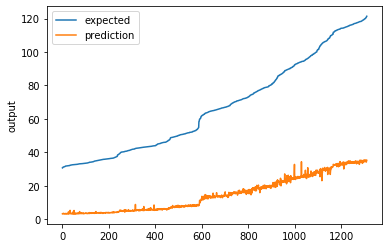

Score (RMSE): 55.1172133130421
Analyzing model with optimizer sgd


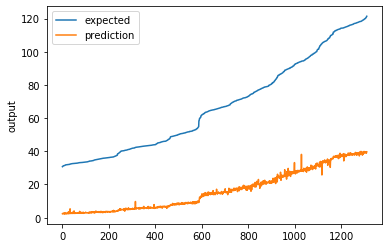

Score (RMSE): 53.27781188886791


In [75]:
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred.flatten(), 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()


for ele in myDict.values():
    print('Analyzing model with optimizer {}'.format(ele[0]))
    model = ele[1]
    pred = model.predict(x_test)
    obs_test = np.asarray(obs_test)
    score = np.sqrt(metrics.mean_squared_error(pred,obs_test))
    chart_regression(pred,obs_test)
    print("Score (RMSE): {}".format(score))

Here we see that both models have a very similar RMSE (implying the optimizer makes little to no difference). Additionally, we see the reression lift chart. We find it a bit odd that there seems to be a relatively consistent linear gap between the expected and the prediction. In other words, it seems odd that our predictions seem to attempt to match the slope of the expected but the y intercept is off by about 20. We assume that this it because we split the data in a linear way

Analyzing model with optimizer adam


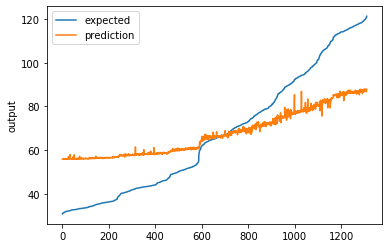

Score (RMSE): 17.394533365517937
Analyzing model with optimizer sgd


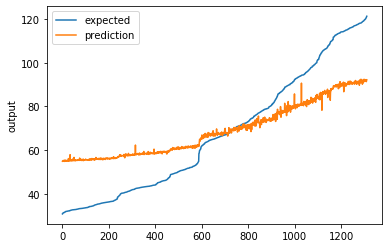

Score (RMSE): 15.879691858016981


In [76]:
for ele in myDict.values():
    print('Analyzing model with optimizer {}'.format(ele[0]))
    model = ele[1]
    pred = model.predict(x_test)
    pred = pred + np.mean(obs_test) - np.mean(obs_train)
    obs_test = np.asarray(obs_test)
    score = np.sqrt(metrics.mean_squared_error(pred,obs_test))
    chart_regression(pred,obs_test)
    print("Score (RMSE): {}".format(score))

We see a slightly improved RMSE, however our curve is too flat. We believe that this is because we have normalized the close price in the input data. We believe this because our model will only be able to notice change in z-scores between close price and use this against an index built on the first 70% of close prices. However, if we included non-normalized close price in our data, we would be able to predict the new close price based on the actual value of the previous close price combined with whatever change value the model predicted. To test our theory, will we model based on non-normalized close price.

In [86]:
dt = pd.read_csv('C:/Users/Owner/Documents/Sac State/CSC215_P2_Stock_Price.csv')
split = int(0.35 * len(dt))
df_train = dt[:split]
df_train = df_train.append(dt[(len(dt) - split):len(dt)])
df_test = dt[split:(len(dt)-split)]

print(len(df_train))
print(len(df_test))

3074
1318


In [92]:
normal_list = ['Open', 'High', 'Low', 'Volume'];

for element in normal_list:
    encode_numeric_zscore(df_train, element)
    encode_numeric_zscore(df_test, element)    



params_train = df_train[['Open', 'High', 'Low', 'Volume', 'Close']].values.tolist()
params_test = df_test[['Open', 'High', 'Low', 'Volume', 'Close',]].values.tolist()

SEQUENCE_SIZE = 7
x_train,y_train = to_sequences(SEQUENCE_SIZE,params_train)
obs_train = df_train['Close'][SEQUENCE_SIZE:len(df_train)].values.tolist()
obs_train.pop()
obs_train = np.asarray(obs_train)
print(obs_train.shape)

x_test,y_test = to_sequences(SEQUENCE_SIZE,params_test)
obs_test = df_test['Close'][SEQUENCE_SIZE:len(df_test)].values.tolist()
obs_test.pop()
obs_test = np.asarray(obs_test)
print(obs_test.shape)


(3066,)
(1310,)


C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [95]:
myDict_mod = dict()
iteration = 0

model = Sequential()
model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(SEQUENCE_SIZE, 5)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')        
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')        
model.fit(x_train,obs_train,validation_data=(x_test,obs_test), callbacks=[monitor],verbose=2, epochs=100)  

myDict_mod.update({iteration : (opt, model)})

Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 27s - loss: 1566.0606 - val_loss: 41.3733
Epoch 2/100
3066/3066 - 18s - loss: 192.4253 - val_loss: 67.7408
Epoch 3/100
3066/3066 - 14s - loss: 26.9222 - val_loss: 83.8275
Epoch 4/100
3066/3066 - 17s - loss: 12.7419 - val_loss: 48.6596
Epoch 5/100
3066/3066 - 15s - loss: 8.5022 - val_loss: 43.5425
Epoch 6/100
3066/3066 - 10s - loss: 7.1813 - val_loss: 57.7913
Epoch 00006: early stopping


Analyzing model with optimizer sgd


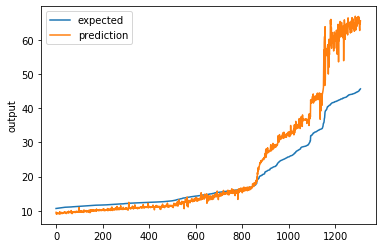

Score (RMSE): 7.602057863016501


In [96]:
for ele in myDict_mod.values():
    print('Analyzing model with optimizer {}'.format(ele[0]))
    model = ele[1]
    pred = model.predict(x_test)
    obs_test = np.asarray(obs_test)
    score = np.sqrt(metrics.mean_squared_error(pred,obs_test))
    chart_regression(pred,obs_test)
    print("Score (RMSE): {}".format(score))

# Fully Connected NN

In [132]:
####################
##Fully Connected NN
####################

####################
##DATA IMPORTING && PREPROCESSING
####################
dt = pd.read_csv('C:/Users/Owner/Documents/Sac State/CSC215_P2_Stock_Price.csv')
dt['Close_y'] = dt['Close']
split = int(0.7 * len(dt))
df_train = dt[:split]
df_test = dt[split:len(dt)]

print("Training set has {} records.".format(len(df_train)))
print("Test set has {} records.".format(len(df_test)))

close_train = df_train['Close_y']
close_test = df_test['Close_y']

def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
        
    if sd is None:
        sd = df[name].std()
        
    df[name] = (df[name] - mean) / sd

normal_list = ['Open', 'High', 'Low', 'Volume', 'Close'];

for element in normal_list:
    encode_numeric_zscore(df_train, element)
    encode_numeric_zscore(df_test, element)    



params_train = df_train[['Open', 'High', 'Low', 'Volume', 'Close']].values.tolist()
params_test = df_test[['Open', 'High', 'Low', 'Volume', 'Close',]].values.tolist()


def to_sequences(seq_size, data):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data[i+SEQUENCE_SIZE]
        window = [x for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

SEQUENCE_SIZE = 7
x_train,y_train = to_sequences(SEQUENCE_SIZE,params_train)
obs_train = close_train[SEQUENCE_SIZE:len(close_train)].values.tolist()
obs_train.pop()
obs_train = np.asarray(obs_train)

x_test,y_test = to_sequences(SEQUENCE_SIZE,params_test)
obs_test = close_test[SEQUENCE_SIZE:len(close_test)].values.tolist()
obs_test.pop()
obs_test = np.asarray(obs_test)


test_NN = []
for ele in x_test:
    flat_list = []
    for sublist in ele:
        for item in sublist:
            flat_list.append(item)
    test_NN.append(flat_list)

train_NN = []
for ele in x_train:
    flat_list = []
    for sublist in ele:
        for item in sublist:
            flat_list.append(item)
    train_NN.append(flat_list)


train_NN = pd.DataFrame(train_NN)
train_NN['out'] = obs_train
test_NN = pd.DataFrame(test_NN)
test_NN['out'] = obs_test


def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)


train_NN,y_train2 = to_xy(train_NN, 'out')
test_NN, y_test2 = to_xy(test_NN, 'out')

Training set has 3074 records.
Test set has 1318 records.


C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [112]:
print(train_NN)
print(test_NN)
print(y_train2)
print(y_test2)

[[-1.0004982  -0.9735974  -0.99670935 ... -1.062878    6.9412484
  -1.0292974 ]
 [-0.97205067 -0.97640973 -0.97944796 ... -1.0297937   2.7910035
  -1.0307183 ]
 [-0.9834296  -0.98484653 -0.9837633  ... -1.0283552   3.2995112
  -1.0221924 ]
 ...
 [ 2.6000443   2.5688512   2.6003346  ...  2.6574128   0.05425843
   2.6184466 ]
 [ 2.5390525   2.5121558   2.5303688  ...  2.6380796   0.69374543
   2.6643732 ]
 [ 2.477606    2.497757    2.5137978  ...  2.6403813   0.74853414
   2.6539145 ]]
[[-0.7823202  -0.66149646 -0.76427567 ... -0.60809183 -0.36558664
  -0.5962742 ]
 [-0.6704499  -0.6872117  -0.6677291  ... -0.58718264 -0.4474715
  -0.5856375 ]
 [-0.67819613 -0.63042396 -0.6610017  ... -0.5940918  -0.32739073
  -0.59771633]
 ...
 [ 1.6375741   1.6228715   1.6526632  ...  1.6788454  -0.7437134
   1.6583192 ]
 [ 1.6440593   1.6207287   1.6399359  ...  1.619572   -0.19747354
   1.6063985 ]
 [ 1.630008    1.6225144   1.6672089  ...  1.5864806   0.01426466
   1.6193787 ]]
[ 3.484375  3.578125 

Moving on to the fully connected neural network. We need to do some data wrangling. First off, we need to change the data from 7 day sequence of 5 fields into a 35 field record. Then, we need to do some structure formatting to interface with tensorflow. After doing preprocessing, we are ready for model building.

In [113]:
myDict2 = dict()
activationType = ['relu', 'sigmoid', 'tanh']
optimizerType = ['adam', 'sgd']
iteration = 0

for act in activationType:
    for opt in optimizerType:
        checkpointer2 = ModelCheckpoint(filepath="C:/Users/Owner/Documents/Sac State/csc215/proj2/best_weights2.hdf5", verbose=0, save_best_only=True) # save best model
        
        for i in range(1):
            print(i)
            model_NN = Sequential()
            model_NN.add(Dense(35, input_dim=train_NN.shape[1], activation=act))
            model_NN.add(Dense(1))
            model_NN.compile(loss='mean_squared_error', optimizer=opt)        
            monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')        
            model_NN.fit(train_NN,y_train2,validation_data=(test_NN,y_test2),callbacks=[monitor, checkpointer2],verbose=2,epochs=100)

        print('Training finished...Loading the best model')  
        print()
        model_NN.load_weights("C:/Users/Owner/Documents/Sac State/csc215/proj2/best_weights2.hdf5") # load weights from best model
        myDict2.update({iteration : (act, opt, model_NN)})
        iteration += 1


0
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 18s - loss: 210.7895 - val_loss: 4253.5541
Epoch 2/100
3066/3066 - 1s - loss: 65.7728 - val_loss: 3569.4628
Epoch 3/100
3066/3066 - 1s - loss: 44.8690 - val_loss: 3488.7006
Epoch 4/100
3066/3066 - 1s - loss: 42.0661 - val_loss: 3461.2532
Epoch 5/100
3066/3066 - 1s - loss: 38.4576 - val_loss: 3464.0966
Epoch 6/100
3066/3066 - 1s - loss: 33.4760 - val_loss: 3420.4331
Epoch 7/100
3066/3066 - 1s - loss: 27.4198 - val_loss: 3350.0659
Epoch 8/100
3066/3066 - 1s - loss: 21.3884 - val_loss: 3302.3737
Epoch 9/100
3066/3066 - 1s - loss: 15.8614 - val_loss: 3259.4184
Epoch 10/100
3066/3066 - 1s - loss: 11.2376 - val_loss: 3251.6178
Epoch 11/100
3066/3066 - 1s - loss: 7.7733 - val_loss: 3191.5909
Epoch 12/100
3066/3066 - 1s - loss: 5.3417 - val_loss: 3180.6238
Epoch 13/100
3066/3066 - 1s - loss: 3.7676 - val_loss: 3153.6434
Epoch 14/100
3066/3066 - 1s - loss: 2.7655 - val_loss: 3103.3519
Epoch 15/100
3066/3066 - 1s - loss: 2

C:\Users\Owner\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:1230: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\Owner\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:995: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


Epoch 2/100
3066/3066 - 1s - loss: nan - val_loss: nan
Epoch 3/100
3066/3066 - 1s - loss: nan - val_loss: nan
Epoch 4/100
3066/3066 - 1s - loss: nan - val_loss: nan
Epoch 5/100
3066/3066 - 1s - loss: nan - val_loss: nan
Epoch 00005: early stopping
Training finished...Loading the best model

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 18s - loss: 280.3626 - val_loss: 4884.9124
Epoch 2/100
3066/3066 - 1s - loss: 219.8564 - val_loss: 4633.0001
Epoch 3/100
3066/3066 - 1s - loss: 176.9858 - val_loss: 4397.5751
Epoch 4/100
3066/3066 - 1s - loss: 138.9309 - val_loss: 4160.9967
Epoch 5/100
3066/3066 - 1s - loss: 106.4769 - val_loss: 3938.4000
Epoch 6/100
3066/3066 - 1s - loss: 80.5117 - val_loss: 3745.2858
Epoch 7/100
3066/3066 - 1s - loss: 61.8800 - val_loss: 3584.1147
Epoch 8/100
3066/3066 - 1s - loss: 48.6424 - val_loss: 3449.2271
Epoch 9/100
3066/3066 - 1s - loss: 39.2449 - val_loss: 3337.0547
Epoch 10/100
3066/3066 - 1s - loss: 32.3807 - val_loss: 3243.5206
E

Similar to our LTSM, we use early stopping and model checkpointing to iterate (and avoid local optima) and save the weights to reference our best model. However, we are iterating through activation layer types as well as optimerizers. An observation about training these models is that they are much faster than the LTSM (in terms of training time per epoch). However, many more epochs are needed to reache the lost cutoff point.

Analyzing model with activation relu and optimizer adam


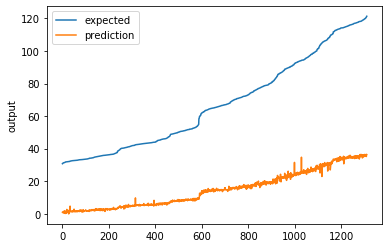

Score (RMSE): 55.163604157686365
Analyzing model with activation relu and optimizer sgd


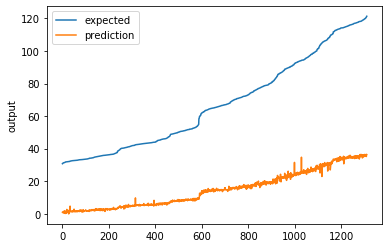

Score (RMSE): 55.163604157686365
Analyzing model with activation sigmoid and optimizer adam


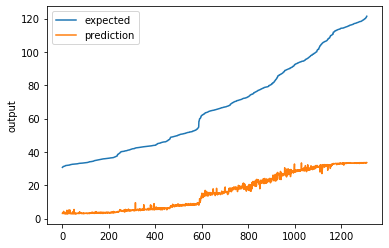

Score (RMSE): 53.891162011847086
Analyzing model with activation sigmoid and optimizer sgd


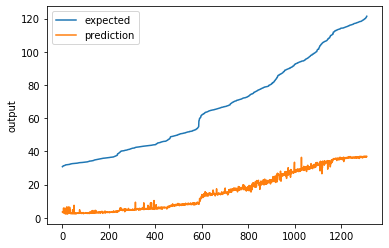

Score (RMSE): 53.63382021022067
Analyzing model with activation tanh and optimizer adam


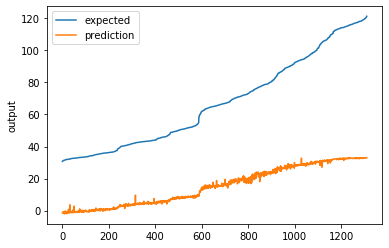

Score (RMSE): 54.521980941405054
Analyzing model with activation tanh and optimizer sgd


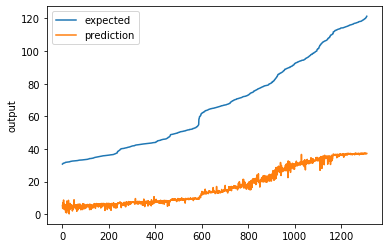

Score (RMSE): 52.67523390970125


In [114]:
for ele in myDict2.values():
    print('Analyzing model with activation {} and optimizer {}'.format(ele[0], ele[1]))
    model_NN = ele[2]
    pred_NN = model_NN.predict(test_NN)
       
    score_NN = np.sqrt(metrics.mean_squared_error(pred_NN,obs_test))
    chart_regression(pred_NN,obs_test)
    print("Score (RMSE): {}".format(score_NN))
    

We see again that our model suffers due to the normalization of the input variable 'Close' we will construct a model this variable in its raw form.

In [129]:
##################
##RAW CLOSE
##################
dt = pd.read_csv('C:/Users/Owner/Documents/Sac State/CSC215_P2_Stock_Price.csv')
dt['Close_y'] = dt['Close']
split = int(0.7 * len(dt))
df_train = dt[:split]
df_test = dt[split:len(dt)]

print("Training set has {} records.".format(len(df_train)))
print("Test set has {} records.".format(len(df_test)))

close_train = df_train['Close_y']
close_test = df_test['Close_y']

def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
        
    if sd is None:
        sd = df[name].std()
        
    df[name] = (df[name] - mean) / sd

normal_list = ['Open', 'High', 'Low', 'Volume'];

for element in normal_list:
    encode_numeric_zscore(df_train, element)
    encode_numeric_zscore(df_test, element)    



params_train = df_train[['Open', 'High', 'Low', 'Volume', 'Close']].values.tolist()
params_test = df_test[['Open', 'High', 'Low', 'Volume', 'Close',]].values.tolist()


SEQUENCE_SIZE = 7
x_train,y_train = to_sequences(SEQUENCE_SIZE,params_train)
obs_train = close_train[SEQUENCE_SIZE:len(close_train)].values.tolist()
obs_train.pop()
obs_train = np.asarray(obs_train)

x_test,y_test = to_sequences(SEQUENCE_SIZE,params_test)
obs_test = close_test[SEQUENCE_SIZE:len(close_test)].values.tolist()
obs_test.pop()
obs_test = np.asarray(obs_test)


test_NN = []
for ele in x_test:
    flat_list = []
    for sublist in ele:
        for item in sublist:
            flat_list.append(item)
    test_NN.append(flat_list)

train_NN = []
for ele in x_train:
    flat_list = []
    for sublist in ele:
        for item in sublist:
            flat_list.append(item)
    train_NN.append(flat_list)


train_NN = pd.DataFrame(train_NN)
train_NN['out'] = obs_train
test_NN = pd.DataFrame(test_NN)
test_NN['out'] = obs_test


def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)


train_NN,y_train2 = to_xy(train_NN, 'out')
test_NN, y_test2 = to_xy(test_NN, 'out')

model_NN = Sequential()
model_NN.add(Dense(35, input_dim=train_NN.shape[1], activation='relu'))
model_NN.add(Dense(1))
model_NN.compile(loss='mean_squared_error', optimizer='adam')        
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')        
model_NN.fit(train_NN,y_train2,validation_data=(test_NN,y_test2),callbacks=[monitor, checkpointer2],verbose=2,epochs=100)

print('Training finished...Loading the best model')  
print()
model_NN.load_weights("C:/Users/Owner/Documents/Sac State/csc215/proj2/best_weights2.hdf5") # load weights from best model
myDict2.update({iteration : (act, opt, model_NN)})
iteration += 1
        
pred_NN = model_NN.predict(test_NN)
       
score_NN = np.sqrt(metrics.mean_squared_error(pred_NN,obs_test))
chart_regression(pred_NN,obs_test)
print("Score (RMSE): {}".format(score_NN))

Training set has 3074 records.
Test set has 1318 records.


C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train on 3066 samples, validate on 1310 samples
Epoch 1/100


KeyboardInterrupt: 

Here we see that our model performs VERY well. It looks like we probably even overfit our data here.

# Extra Features

In [ ]:
dt = pd.read_csv('C:/Users/Owner/Documents/Sac State/CSC215_P2_Stock_Price.csv')
split = int(0.35 * len(dt))
df_train = dt[:split]
df_train = df_train.append(dt[(len(dt) - split):len(dt)])
df_test = dt[split:(len(dt)-split)]

normal_list = ['Open', 'High', 'Low', 'Volume'];

for element in normal_list:
    encode_numeric_zscore(df_train, element)
    encode_numeric_zscore(df_test, element)    



params_train = df_train[['Open', 'High', 'Low', 'Volume', 'Close']].values.tolist()
params_test = df_test[['Open', 'High', 'Low', 'Volume', 'Close',]].values.tolist()

for x in range(5,15):
    SEQUENCE_SIZE = x
    x_train,y_train = to_sequences(SEQUENCE_SIZE,params_train)
    obs_train = df_train['Close'][SEQUENCE_SIZE:len(df_train)].values.tolist()
    obs_train.pop()
    obs_train = np.asarray(obs_train)
    #print(obs_train.shape)
    
    x_test,y_test = to_sequences(SEQUENCE_SIZE,params_test)
    obs_test = df_test['Close'][SEQUENCE_SIZE:len(df_test)].values.tolist()
    obs_test.pop()
    obs_test = np.asarray(obs_test)
    #print(obs_test.shape)
    
    
    myDict_seq = dict()
    iteration = x-5
    
    model = Sequential()
    model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(SEQUENCE_SIZE, 5)))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')        
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')        
    model.fit(x_train,obs_train,validation_data=(x_test,obs_test), callbacks=[monitor],verbose=2, epochs=100)  
    
    print("Analyzing Model with {} sequence length".format(x))
    model.predict(x_test)
    obs_test = np.asarray(obs_test)
    score = np.sqrt(metrics.mean_squared_error(pred_seq,obs_test))
    chart_regression(pred_seq,obs_test)
    print("Score (RMSE): {}".format(score))
    
    myDict_seq.update({iteration : (model, x_test, obs_test)})

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train on 3068 samples, validate on 1312 samples
Epoch 1/100
3068/3068 - 26s - loss: 1556.4569 - val_loss: 119.8831
Epoch 2/100
3068/3068 - 12s - loss: 203.0883 - val_loss: 295.7139
Epoch 3/100
3068/3068 - 12s - loss: 31.3490 - val_loss: 201.3664
Epoch 4/100
3068/3068 - 10s - loss: 16.1090 - val_loss: 146.3972
Epoch 5/100
3068/3068 - 10s - loss: 10.5297 - val_loss: 126.6852
Epoch 6/100
3068/3068 - 10s - loss: 8.6050 - val_loss: 104.5369
Epoch 7/100


In [131]:
for ele in myDict_seq:
    x_train,y_train = to_sequences(ele,params_train)
    obs_train = df_train['Close'][ele:len(df_train)].values.tolist()
    obs_train.pop()
    obs_train = np.asarray(obs_train)
    
    x_test,y_test = to_sequences(ele,params_test)
    print(len(params_test))
    print(len(x_test))
    obs_test = df_test['Close'][ele:len(df_test)].values.tolist()
    obs_test.pop()
    obs_test = np.asarray(obs_test)
    
    
    print('Analyzing model wth sequence length {}'.format(ele))
    model_seq = myDict_seq[ele]
    pred_seq = model_seq.predict(x_test)
    obs_test = np.asarray(obs_test)
    score = np.sqrt(metrics.mean_squared_error(pred_seq,obs_test))
    chart_regression(pred_seq,obs_test)
    print("Score (RMSE): {}".format(score))

1318
1310
Analyzing model with sequence length 9


ValueError: Error when checking input: expected lstm_44_input to have shape (14, 5) but got array with shape (7, 5)